In [1]:
import numpy as np
import psutil
import matplotlib.pyplot as plt
import time
from lab2_proto import *

We're going to investigate phonetic models for digit classification. There are 21 phonetic models, each one is a HMM with 1 Gaussian emission probability distribution per state.

In [2]:
phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
wordHMMs = {}
# we take HMM models and return the concatenation of these
wordHMMs['o'] = concatHMMs(phoneHMMs, ['sil', 'ow', 'sil'])
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()

In [3]:
list(example.keys())

['filename',
 'samplingrate',
 'gender',
 'speaker',
 'digit',
 'repetition',
 'samples',
 'lmfcc',
 'obsloglik',
 'logalpha',
 'loglik',
 'vloglik',
 'vpath',
 'logbeta',
 'loggamma']

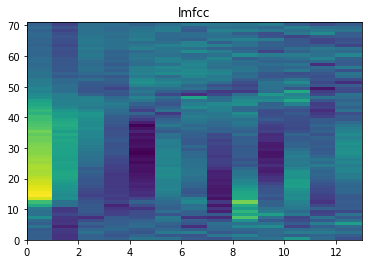

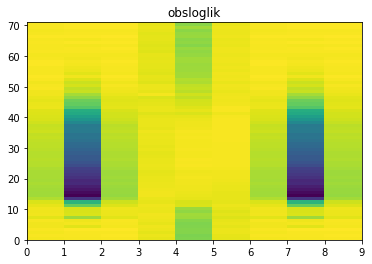

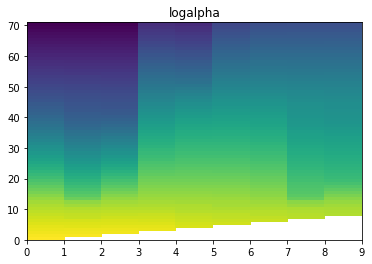

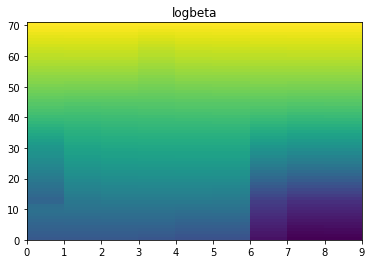

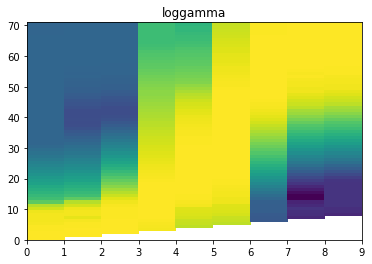

In [4]:
# the model example plots that we aim to reproduce
plotList=['lmfcc','obsloglik','logalpha','logbeta','loggamma']
for p in plotList:
    plt.title(p)
    plt.pcolormesh(example[p],cmap=None)
    plt.show()

We get the same obsloglik


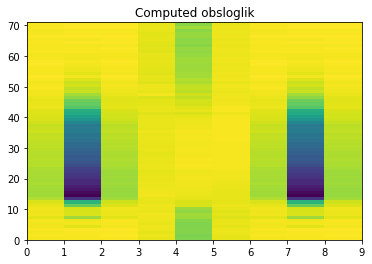

In [5]:
obsloglik_=log_multivariate_normal_density_diag(example['lmfcc'],wordHMMs['o']['means'],wordHMMs['o']['covars'])
if(np.allclose(obsloglik_,example['obsloglik'],atol=10-8)):
    print('We get the same obsloglik')
plt.pcolormesh(obsloglik_)
plt.title('Computed obsloglik')
plt.show()


## 5.1 Gaussian emission probabilities

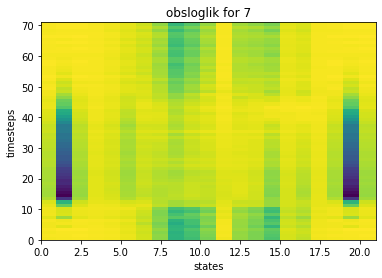

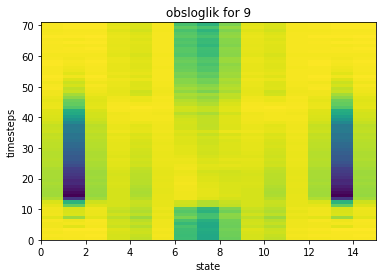

In [6]:
prondict = {} 
prondict['o'] = ['ow']
prondict['z'] = ['z', 'iy', 'r', 'ow']
prondict['1'] = ['w', 'ah', 'n']
prondict['2'] = ['t', 'uw']
prondict['3'] = ['th', 'r', 'iy']
prondict['4'] = ['f', 'ao', 'r']
prondict['5'] = ['f', 'ay', 'v']
prondict['6'] = ['s', 'ih', 'k', 's']
prondict['7'] = ['s', 'eh', 'v', 'ah', 'n']
prondict['8'] = ['ey', 't']
prondict['9'] = ['n', 'ay', 'n']

obsloglik={}
for p in prondict.keys():
    # add silence to the start and end of digit 
    listnames=['sil']+prondict[p]+['sil'] 
    # concatenate models and calculate log likelihood for gaussians for HMM models corresponding to digit p
    wordHMMs[p]=concatHMMs(phoneHMMs, listnames) 
    obsloglik[p]=log_multivariate_normal_density_diag(example['lmfcc'],wordHMMs[p]['means'],wordHMMs[p]['covars'])

plt.pcolormesh(obsloglik['7'])
plt.xlabel('states')
plt.ylabel('timesteps')
plt.title('obsloglik for 7')
plt.show()

plt.pcolormesh(obsloglik['9'])
plt.xlabel('state')
plt.ylabel('timesteps')
plt.title('obsloglik for 9')
plt.show()

We see that the start and end loglikelihoods are very small (-600 <= blue <= -300]) to indicate silence then the rest. 

Gaussian components near the middle give the highest likelihood for the utterance observations. 

## 5.2 Forward Algorithm

In [7]:
def forward(log_emlik, log_startprob, log_transmat):
    """Forward (alpha) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: log transition probability from state i to j

    Output:
        forward_prob: NxM array of forward log probabilities for each of the M states in the model
    """
    
    alpha = np.zeros(np.shape(log_emlik))
    N=len(alpha)
    # recursiveAlpha(N-1, alpha, log_emlik, log_startprob, log_transmat)
    alpha[0][:] = log_startprob.T + log_emlik[0]

    for n in range(1,len(alpha)):
        for i in range(alpha.shape[1]):
            alpha[n, i] = logsumexp(alpha[n - 1] + log_transmat[:,i]) + log_emlik[n,i]
    return alpha, logsumexp(alpha[N-1])
   


The likelihood can be computed as <br>
$P(X | \lambda)=\sum_{i=1}^{N} \alpha_{T}(i)$

In [8]:
alpha, likelihood=forward(obsloglik['o'],np.log(wordHMMs['o']['startprob'][0:-1]),np.log(wordHMMs['o']['transmat'][0:-1,0:-1]))

if(example['loglik']==likelihood):
    print('We get the same likelihood:',likelihood)

We get the same likelihood: -5970.427602563561


In [9]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
import pandas as pd

def plot_confusion_matrix(ground_truth, predictions, labels):
    cm=confusion_matrix(ground_truth, predictions, labels=labels)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    sn.set(font_scale=0.9) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt="d") # font size
    plt.ylabel('Ground truth')
    plt.xlabel('Predicted utterance')
    plt.show()
    print('Accuracy:', accuracy_score(ground_truth, predictions))



In [11]:
def apply_forward_algorithm(measure_cpu=False, plot_confusion_mtx=True):
    likelihood_list={}
    # we calculate log likelihood of each observation possibility (each digit) for each sample        
    
    dict_idx=['o', 'z', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    accuracy=0
    gt = []
    pred = []

    cpu_usage = []
    psutil.cpu_percent() # first time its called, returns 0.0 which we should ignore

    start_time = time.time()

    for d in range(data.shape[0]):
        likelihood_list = []
        for w in wordHMMs.keys(): 
            obsloglik_temp=log_multivariate_normal_density_diag(data[d]['lmfcc'],wordHMMs[w]['means'],wordHMMs[w]['covars'])
            alpha, likelihood=forward(obsloglik_temp,np.log(wordHMMs[w]['startprob'][0:-1]),np.log(wordHMMs[w]['transmat'][0:-1,0:-1]))
            likelihood_list.append(likelihood)

        # calculate index of digit with highest likelihood for utterance d in datasett
        index=np.argmax(likelihood_list)
        gt.append(data[d]['digit'])
        pred.append(dict_idx[index])

        if(dict_idx[index]==data[d]['digit']):
            accuracy+=1

        if measure_cpu:
            cpu_usage.append(psutil.cpu_percent())
            
    end_time = time.time()

    if measure_cpu:
        print('Avg cpu percantage used', np.mean(cpu_usage))
        print('Max cpu percentage used', np.max(cpu_usage))
        print('Duration', end_time-start_time)

    print('Accuracy', accuracy/len(data))

    if plot_confusion_mtx:
        plot_confusion_matrix(gt, pred, dict_idx)

Accuracy 0.7727272727272727


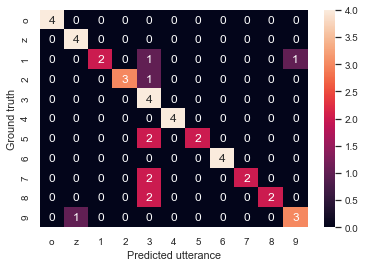

Accuracy: 0.7727272727272727


In [12]:
apply_forward_algorithm()

## 5.3 Viterbi 

The Viterbi recursion formulas are as follows:<br>
$ \log{V_0(j)} = \log{\pi_j} + \log_{\phi_j} {x_0}$ <br>
$\log{V_n(j)} = \max_{i=0}^{M - 1} (\log{V_{n - 1}(i)} + \log{a_{ij})} + \log_{\phi_{j}}{x_n}$

To recover the best path:<br>
$B_n(j) = argmax_{i=0}^{M - 1} (\log {V_{n - 1}(i)} + \log {a_{ij}})$


In [13]:
# we don't pass in end state
viterbi_log_lik, viterbi_best_path = viterbi(obsloglik_, np.log(wordHMMs['o']['startprob'][:-1]), np.log(wordHMMs['o']['transmat'][:-1,:-1]))
print(viterbi_log_lik)
print(example['vloglik'] )
print(viterbi_log_lik == example['vloglik'])


-5974.211288357338
-5974.211288357338
True


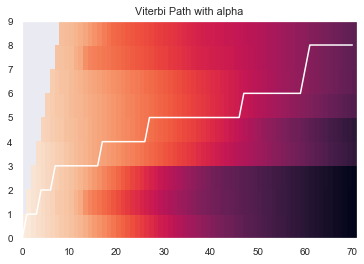

In [14]:

viterbiPath=np.asarray(viterbi_best_path)
bestPath=np.zeros((alpha.shape))
for i in range(len(viterbi_best_path)):
    # print(viterbiPath[i])
    bestPath[i][viterbiPath[i].astype(int)]=1
plt.plot(viterbiPath,'-', color="w")
plt.pcolormesh(alpha.T)
plt.title('Viterbi Path with alpha')
plt.show()
# plt.pcolormesh(bestPath)
# plt.show()
# viterbiPath

Accuracy: 0.7727272727272727


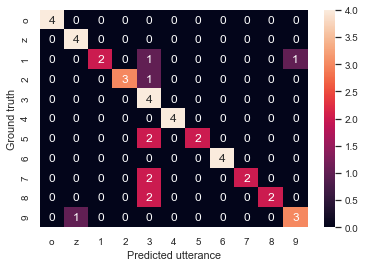

Accuracy: 0.7727272727272727


In [15]:
def apply_viterbi(measure_cpu=False, plot_confusion_mtx=True):
    logliks = np.zeros(((len(data), len(wordHMMs))))
    gts = []
    preds = []
    lbls = list(wordHMMs.keys())
    accuracy = 0
    
    cpu_usage = []
    
    psutil.cpu_percent() # first time its called, returns 0.0 which we should ignore

    start_time = time.time()
    for i, utterance in enumerate(data):
        gts.append(data[i]['digit'])
        ''' loop over all digits and calculate the likelihood of the utterance corresponding to the utterance '''
        for j, digit in enumerate(lbls):
            obs_log_lik = log_multivariate_normal_density_diag(utterance['lmfcc'], wordHMMs[digit]['means'], wordHMMs[digit]['covars'])
            viterbi_log_lik, viterbi_best_path = viterbi(obs_log_lik, np.log(wordHMMs[digit]['startprob'][:-1]), np.log(wordHMMs[digit]['transmat'][:-1,:-1])) 
            logliks[i,j] = viterbi_log_lik
        ''' obtain digit with highest loglikeihood for utterance i'''
        predicted_digit = lbls[np.argmax(logliks[i,:])]
        if predicted_digit == data[i]['digit']:
            accuracy += 1
        preds.append(predicted_digit)
        if measure_cpu:
            cpu_usage.append(psutil.cpu_percent())
    end_time = time.time()
    
    if measure_cpu:
        print('Avg cpu percantage used', np.mean(cpu_usage))
        print('Max cpu percentage used', np.max(cpu_usage))
        print('Duration', end_time-start_time)

    print('Accuracy:', accuracy/len(data))
    if plot_confusion_mtx:
        plot_confusion_matrix(gts, preds, lbls)


apply_viterbi()

In [16]:
# TODO measure CPU usage of viterbi scoring compared to forward scoring and comment on complexity 
print('Forward Algorithm')
apply_forward_algorithm(measure_cpu=True, plot_confusion_mtx=False)

print('\nViterbi')
apply_viterbi(measure_cpu=True, plot_confusion_mtx=False)


Forward Algorithm
Avg cpu percantage used 17.186363636363637
Max cpu percentage used 38.2
Duration 19.12577486038208
Accuracy 0.7727272727272727

Viterbi
Avg cpu percantage used 18.095454545454547
Max cpu percentage used 50.0
Duration 1.1111550331115723
Accuracy: 0.7727272727272727


## 5.4 Backward algorithm

We calculate the probabilities of observing the rest of the sequence after timestep i given that at timestep i we are in state k in the HMM:<br>
$b_k(i) = P(x_{i+1},...,x_L | \pi_i = k)$<br>

$ b_k(i) = a_{kl}*e_l(x_{i+1})*b_l(i + 1)$

In [17]:
wordHMMs['o'].keys()

dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])

likelihood from backward algorithm
$P(O | \lambda)=\sum_{i=1}^{N} \pi_{i} \cdot b_{i}\left(O_{1}\right) \cdot \beta_{1}(i)$


In [18]:
# we don't pass in end state
backward_prob = backward(obsloglik['o'], np.log(wordHMMs['o']['startprob'][:-1]), np.log(wordHMMs['o']['transmat'][:-1,:-1]))

if(np.allclose(backward_prob, example['logbeta'], atol=10-8)):
    print('We get the same logbetas.')
# from scipy.misc import logsumexp as lse
ll=logsumexp(backward_prob[0]+np.log(wordHMMs['o']['startprob'][:-1])+obsloglik['o'][0])
print('likelihood computed from backward algorithm is :',ll)





We get the same logbetas.
likelihood computed from backward algorithm is : -5970.427602563565


## HMM Retraining 

### 6.1 State posterior probabilities

In [19]:
from lab2_tools import logsumexp
def statePosteriors(log_alpha, log_beta):
    """State posterior (gamma) probabilities in log domain.

    Args:
        log_alpha: NxM array of log forward (alpha) probabilities
        log_beta: NxM array of log backward (beta) probabilities
    where N is the number of frames, and M the number of states

    Output:
        log_gamma: NxM array of gamma probabilities for each of the M states in the model
    """
    N, M = log_alpha.shape
    log_gamma=np.zeros((N,M))
    N = len(log_alpha)
    log_gamma = log_alpha + log_beta - logsumexp(log_alpha[N - 1])

    # for n in range(N):
    #     for i in range(M):
    #         log_gamma[n][i]=log_alpha[n][i]+log_beta[n][i]-logsumexp(log_alpha[N-1,:])
    return log_gamma


The state posteriors for the utterance sum to one (in linear domain).

In [20]:
posterior=statePosteriors(example['logalpha'],example['logbeta'])
if(np.allclose(posterior, example['loggamma'], atol=10-8)):
    print('We get the same Posterior.')



We get the same Posterior.


In [21]:
checkPosterior=np.exp(posterior)
np.sum(checkPosterior,axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

Summing over both states and time steps = the length of the observation sequence

In [22]:
np.sum(checkPosterior)

70.99999999991067

Comparision of emission probabilities from GMM model to state
posteriors from HMM

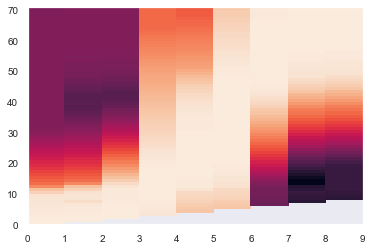

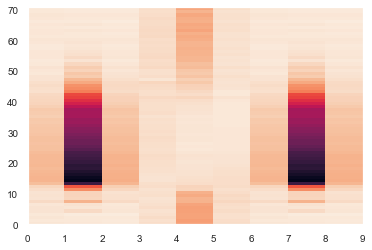

In [23]:
plt.pcolormesh(posterior,cmap=None)
plt.show()

plt.pcolormesh(obsloglik['o'],cmap=None)
plt.show()

### 6.2 Retraining the emission probability distributions

In [24]:
def updateMeanAndVar(X, log_gamma, varianceFloor=5.0):
     """ Update Gaussian parameters with diagonal covariance

     Args:
          X: NxD array of feature vectors
          log_gamma: NxM state posterior probabilities in log domain
          varianceFloor: minimum allowed variance scalar
          were N is the lenght of the observation sequence, D is the
          dimensionality of the feature vectors and M is the number of
          states in the model

     Outputs:
          means: MxD mean vectors for each state
          covars: MxD covariance (variance) vectors for each state
     """
     N,D=X.shape
     M=log_gamma.shape[1]
     means=np.zeros((M,D))
     covars=np.zeros((M,D))
     gamma=np.exp(log_gamma)
     for m in range(M):
          means[m]=np.sum(gamma[:,m].reshape(-1,1)*X,axis=0)/np.sum(gamma[:,m])
          covars[m]=np.sum(gamma[:,m].reshape(-1,1)*np.power((X-means[m]),2),axis=0)/np.sum(gamma[:,m])
     covars=np.where(covars<varianceFloor,varianceFloor,covars)
     return means,covars          

In [25]:
# example['lmfcc'].shape
# posterior.shape
mean,cov=updateMeanAndVar(example['lmfcc'],posterior)


In [26]:
import matplotlib.pyplot as plt 

def baum_welch(X, wordHMM, max_iter=20, thresh=1.0,plotLikelihood=False):
    ''' 
    Params:
        X: lmfcc features for utterance
        wordHMM: HMM models for words
        max_iter: maximum number of iterations to run baum welch algorithm for
        thresh: stopping criteria for baum welch. Algorithm stops when log likelihood no longer increases by >= thresh 
    Returns:
        likelihood: likelihood of data given final model
    '''
    curr_likelihood = None
    likelihood = 0
    plt_=[]

    for i in range(max_iter):
        # expectatiton step: compute alpha, beta and gamma probabilities for utterance using current model parameters
        obsloglik = log_multivariate_normal_density_diag(X, wordHMM['means'], wordHMM['covars']) # problem is here with nans
        alphas, likelihood = forward(obsloglik, np.log(wordHMM['startprob'][:-1]), np.log(wordHMM['transmat'][:-1, :-1]))
        betas = backward(obsloglik, np.log(wordHMM['startprob'][:-1]), np.log(wordHMM['transmat'][:-1, :-1]))
        # maximisation step: update means and variances using posteriors (gammas)
        gammas = statePosteriors(alphas, betas)
        wordHMM['means'], wordHMM['covars'] = updateMeanAndVar(X, gammas)

        # estimate likelihood of data given new model 
       
        if curr_likelihood is not None and likelihood < (curr_likelihood + thresh):
            break

        curr_likelihood = likelihood
        plt_.append(curr_likelihood)

    print('Number of iterations', i+1)
    print('Likelihood', likelihood)
    if(plotLikelihood):
        plt.plot(plt_)
        plt.xlabel('Iteration')
        plt.ylabel('log likelihood')
        plt.show()
    return likelihood, plt_


Number of iterations 8
Likelihood -6301.455462656534


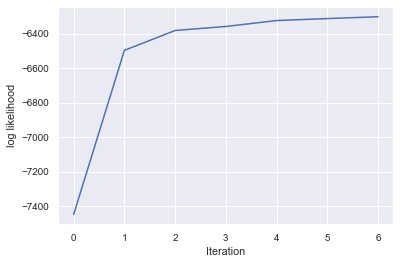

In [27]:

b=wordHMMs['o'].copy()
lik, plt_ = baum_welch(data[10]['lmfcc'], b, max_iter=10,plotLikelihood=True)


Number of iterations 8
Likelihood -6301.455462656534
Number of iterations 5
Likelihood -5936.385540362124
Number of iterations 11
Likelihood -6054.588062278952
Number of iterations 11
Likelihood -6202.968018082496
Number of iterations 5
Likelihood -6151.934110176126
Number of iterations 12
Likelihood -5963.160696113787
Number of iterations 6
Likelihood -5987.855040558538
Number of iterations 20
Likelihood nan
Number of iterations 20
Likelihood nan
Number of iterations 7
Likelihood -6180.771825944545
Number of iterations 4
Likelihood -6065.752624667125


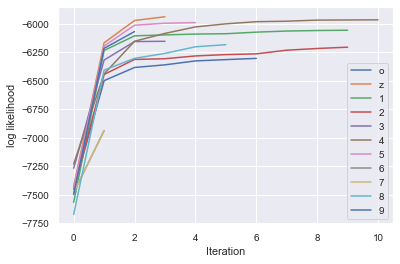

In [28]:
for digit in wordHMMs.keys():
    b = wordHMMs[digit].copy()
    lik, plt_ = baum_welch(data[10]['lmfcc'], b) # 'four'
    plt.plot(plt_, label=digit)
    
plt.xlabel('Iteration')
plt.ylabel('log likelihood')
plt.legend()
plt.show()